In [190]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#adapted from
#https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

In [191]:
# Load Dataset
ilinet_full = pd.DataFrame(pd.read_csv('ILINet.csv'))
ilinet_full

,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,2004,40,0.982275,0.897159,877,1256,185,3171,1176,353449
1,2004,41,1.018210,1.022480,1071,1373,216,3631,1187,355116
2,2004,42,1.176800,1.062960,1240,1534,226,4019,1267,378094
3,2004,43,1.301210,1.146960,1190,1671,285,4369,1293,380921
4,2004,44,1.277460,1.204950,1327,1718,291,4551,1302,377692
...,...,...,...,...,...,...,...,...,...,...
804,2020,10,5.130780,5.290100,13581,25957,5586,77452,2853,1464094
805,2020,11,5.631160,6.345940,13834,27321,6603,88341,2769,1392087
806,2020,12,6.357030,7.450870,10612,17276,6925,77817,2697,1044402
807,2020,13,5.178310,6.391350,5064,8245,6393,52802,2561,826148


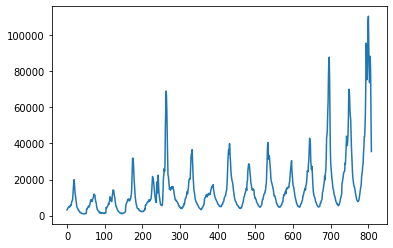

In [192]:
plt.plot(ilinet_full['ILITOTAL'])
plt.show()

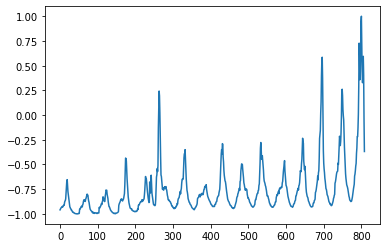

In [193]:
#normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
data=scaler.fit_transform(ilinet_full['ILITOTAL'].values.reshape(-1, 1))
plt.plot(data)

In [194]:
#MMR seasons start and end
end_weeks=ilinet_full.index[ilinet_full['WEEK'] == 39].tolist()
start_weeks=ilinet_full.index[ilinet_full['WEEK'] == 40].tolist()

In [195]:
#729 is the end of the 2018 season
train_data_size = 729

# divide data into training and testing,
train_data =data[0:-52*2]
test_data =data[-52*2:]
print(len(train_data))
print(len(test_data))

705
104


In [196]:
#divide data into windows
train_data = torch.FloatTensor(train_data).view(-1)
train_window = 52

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data, train_window)

In [197]:
len(train_inout_seq[1][0])

52

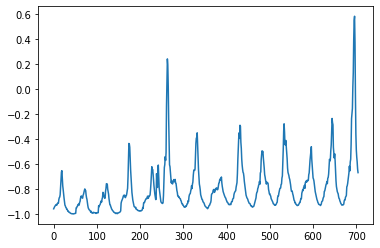

In [198]:
plt.plot(train_data)

In [199]:
#define model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [200]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [201]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


# full season predictions from past seasons

In [209]:
epochs = 80#150

losses=[]
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        losses.append(single_loss)
        single_loss.backward()
        optimizer.step()
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00668839
epoch:  26 loss: 0.00018911
epoch:  51 loss: 0.00015828
epoch:  76 loss: 0.00291780
epoch:  79 loss: 0.0003062035


In [210]:
losses=[float(i) for i in losses]

79

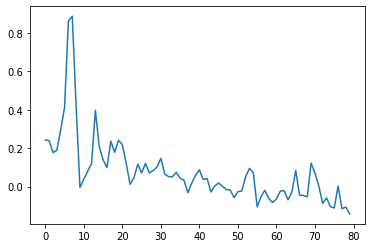

In [211]:
lossperepoch  =[]
sep=int(len(losses)/epochs)
c=0
for i in range(0,len(losses),sep):
    lossperepoch.append(sum(losses[c*sep:c*sep+sep]))
    c=c+1
plt.plot(range(0,epochs),np.log(lossperepoch))
np.argmin(lossperepoch)

In [212]:
fut_pred = train_window
test_data = torch.FloatTensor(test_data).view(-1)
test_inputs = test_data[-train_window:].tolist()

In [213]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [214]:
actual_predictions = np.array(test_inputs[train_window:])

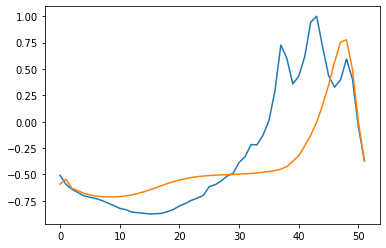

In [215]:
plt.plot(test_data[-fut_pred:])
plt.plot(actual_predictions)
plt.show()

Next steps:

- use less training data to predict

- smaller training window (try 10 instead of 52)

- use hopitalization data instread of total case counts (easy change)


# Smaller training window - 10

In [ ]:
#smaller training window (try 10 instead of 52)
train_window = 10
train_inout_seq = create_inout_sequences(train_data, train_window)
epochs = 20

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [ ]:
fut_pred = 10

test_inputs = train_data[-train_window:].tolist()

In [ ]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
actual_predictions = np.array(test_inputs[train_window:])
x = np.arange(len(train_data), len(train_data)+10, 1)
print(x)
plt.plot(data[len(train_data):len(train_data)+10])
plt.plot(actual_predictions)
plt.show()

Predictions for smaller training window does not work
- cannot capture time series relationships for this small a window

# Use past two seasons data to predict next 10 weeks


In [ ]:
#print(start_weeks)
train_data = data[626:729+10]
train_data = torch.FloatTensor(train_data).view(-1)
train_window = 52
train_inout_seq = create_inout_sequences(train_data, train_window)
plt.plot(train_data)

In [ ]:
epochs = 80

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [ ]:
fut_pred = 10

test_inputs = train_data[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
actual_predictions = np.array(test_inputs[train_window:])
x = np.arange(len(train_data), len(train_data)+10, 1)


In [ ]:
plt.plot(data[len(train_data):len(train_data)+10])
plt.plot(actual_predictions)
plt.show()

Using less training data also gave less accurate predictions for next 10 weeks of current season.

# Use hopitalization data instread of total case counts 
 (reflects the Rona data better)

In [ ]:
#plt.plot(ilinet_full['% WEIGHTED ILI'].values)
data=scaler.fit_transform(ilinet_full['% WEIGHTED ILI'].values.reshape(-1, 1))
plt.plot(data)

In [ ]:
train_data = data[0:729]
train_data = torch.FloatTensor(train_data).view(-1)
train_window = 52
train_inout_seq = create_inout_sequences(train_data, train_window)

In [ ]:
epochs = 10

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [ ]:
fut_pred = 10

test_inputs = train_data[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
actual_predictions = np.array(test_inputs[train_window:])
x = np.arange(len(train_data), len(train_data)+10, 1)
#print(x)
#plt.plot(data[0:len(train_data)+10])
#plt.plot(x,actual_predictions)
#plt.show()

In [ ]:
plt.plot(data[len(train_data):len(train_data)+10])
plt.plot(actual_predictions)
plt.show()

 # testing

In [ ]:
train_data = data[0:round(len(data)*.7)]
test_data = data[round(len(data)*.7):]
train_data = torch.FloatTensor(train_data).view(-1)
test_data = torch.FloatTensor(test_data).view(-1)
train_window = 52
train_inout_seq = create_inout_sequences(train_data, train_window)


In [ ]:
epochs = 25

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [ ]:
#making predictions on training data
fut_pred = 10

test_inputs = train_data[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
actual_predictions = np.array(test_inputs[train_window:])
x = np.arange(len(train_data), len(train_data)+10, 1)
print(x)
plt.plot(data[len(train_data):len(train_data)+10])
plt.plot(actual_predictions)
plt.show()

In [ ]:
#making predictions on testing data
fut_pred = 10

test_inputs = test_data[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
actual_predictions = np.array(test_inputs[train_window:])
x = np.arange(len(test_data), len(test_data)+10, 1)
print(x)
plt.plot(data[len(test_data):len(test_data)+10])
plt.plot(actual_predictions)
plt.show()

 # Conclusions for these steps
 - The LSTM network needs lots of data to make decent predictions for next 10 weeks
 - Was able to predict hospitalization data trend
 - Instead of national data, use state level for more windows to train with
 - try a more sophisticated model - seq2seq

# Using state data

In [ ]:
ilinet_full_state = pd.DataFrame(pd.read_csv('ILINet_mod_state.csv'))
ilinet_full_state

In [ ]:
#remove missing data
FL=ilinet_full_state.index[ilinet_full_state['REGION'] == 'Florida'].tolist()
ilinet_full_state= ilinet_full_state[~ilinet_full_state.index.isin(FL)]
CM=ilinet_full_state.index[ilinet_full_state['REGION'] == 'Commonwealth of the Northern Mariana Islands'].tolist()
ilinet_full_state= ilinet_full_state[~ilinet_full_state.index.isin(CM)]

In [ ]:
#Arrange by state
region_names =ilinet_full_state['REGION'][0:51]#0:51
df = pd.DataFrame(columns = region_names)
for region in region_names:
    indices = ilinet_full_state.index[ilinet_full_state['REGION'] == region].tolist()
    state = ilinet_full_state[ilinet_full_state.index.isin(indices)]["%UNWEIGHTED ILI"].values
    state = [float(i) for i in state]
    df[region]=state

In [ ]:
df

In [ ]:
#create list with all data
data = []
for region in region_names:
    data = data + df[region].values.tolist()

In [ ]:
train_data = data[0:round(len(data)*.7)]
test_data = data[round(len(data)*.7):]
train_data = torch.FloatTensor(train_data).view(-1)
test_data = torch.FloatTensor(test_data).view(-1)
train_window = 52
train_inout_seq = create_inout_sequences(train_data, train_window)

In [ ]:
epochs = 25

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [ ]:
#making predictions on training data
fut_pred = 10

test_inputs = train_data[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
actual_predictions = np.array(test_inputs[train_window:])
x = np.arange(len(train_data), len(train_data)+10, 1)

plt.plot(data[len(train_data):len(train_data)+10])
plt.plot(actual_predictions)
plt.show()
#plt.plot(data[0:len(train_data)+10])
#plt.plot(x,actual_predictions)
#plt.show()

# Using first 10 weeks to predict peak intensity

In [ ]:
ilinet_full_state = pd.DataFrame(pd.read_csv('ILINet_mod_state.csv'))
#remove missing data
FL=ilinet_full_state.index[ilinet_full_state['REGION'] == 'Florida'].tolist()
ilinet_full_state= ilinet_full_state[~ilinet_full_state.index.isin(FL)]
CM=ilinet_full_state.index[ilinet_full_state['REGION'] == 'Commonwealth of the Northern Mariana Islands'].tolist()
ilinet_full_state= ilinet_full_state[~ilinet_full_state.index.isin(CM)]
ilinet_full_state

In [ ]:
#Arrange by state
region_names =ilinet_full_state['REGION'][0:51]#0:51
df = pd.DataFrame(index=range(len(ilinet_full_state)),columns = ilinet_full_state.columns)
c = 0
for region in region_names:
    indices = ilinet_full_state.index[ilinet_full_state['REGION'] == region].tolist()
    state = ilinet_full_state[ilinet_full_state.index.isin(indices)]
    for col in ilinet_full_state.columns:
        df[col][c:c+len(state)] = state[col].values
    c = c+len(state)
df = df[0:25296]
df

In [ ]:
#scale
vals=[float(i) for i in ilinet_full_state['%UNWEIGHTED ILI'].values]
avg = np.mean(vals)
std = np.std(vals)
#print((vals[0:100]-avg)/std)

In [ ]:
# data set with key features
X_data =[]
y_data =[]

for region in region_names:
    
    indices = df.index[df['REGION'] == region].tolist()
    state = df[df.index.isin(indices)]
    
    end_weeks=state.index[state['WEEK'] == 39].tolist()
    
    start_weeks=state.index[state['WEEK'] ==40].tolist() 
    #get a season
    for i in range(len(start_weeks)-1):
        season = df[start_weeks[i]:end_weeks[i]+1]
        
        #extract key features
        first = season['%UNWEIGHTED ILI'][0:10].values #might want to go back and make this >.02
        first=[float(i) for i in first]
        first = (first-avg)/std

        
        peak_intensity=float(season['%UNWEIGHTED ILI'].values.max())
        peak_intensity = (peak_intensity-avg)/std
        
        #wk = season.index[season['%UNWEIGHTED ILI']== season['%UNWEIGHTED ILI'].values.max()]
        #peak_wk=float(season['WEEK'][wk].values)/52
        
        X_data.append(first)
        y_data.append([peak_intensity])
        
X=torch.tensor((X_data[:-1]), dtype=torch.float)
y=torch.tensor((y_data[:-1]), dtype=torch.float)
xPredicted = torch.tensor((X_data[-1]), dtype=torch.float) # 1 X 2 tensor
yTrue = torch.tensor((y_data[-1]), dtype=torch.float)

In [ ]:
# scale units
X_max, _ = torch.max(X, 0)
xPredicted_max, _ = torch.max(xPredicted, 0)

X = torch.div(X, X_max)
xPredicted = torch.div(xPredicted, xPredicted_max)

y_max, _ = torch.max(y, 0)
y = torch.div(y, y_max)

In [ ]:
print(X.size())
print(y.size())

In [ ]:
class Neural_Network(nn.Module):
    def __init__(self, ):
        super(Neural_Network, self).__init__()
        # parameters
        # TODO: parameters can be parameterized instead of declaring them here
        self.inputSize = 10
        self.outputSize = 1
        self.hiddenSize = 10
        
        # weights
        self.W1 = torch.randn(self.inputSize, self.hiddenSize) # 2 X 3 tensor
        self.W2 = torch.randn(self.hiddenSize, self.outputSize) # 3 X 1 tensor
        
    def forward(self, X):
        self.z = torch.matmul(X, self.W1) # 3 X 3 ".dot" does not broadcast in PyTorch
        self.z2 = self.sigmoid(self.z) # activation function
        self.z3 = torch.matmul(self.z2, self.W2)
        o = self.sigmoid(self.z3) # final activation function
        return o
        
    def sigmoid(self, s):
        return 1 / (1 + torch.exp(-s))
    
    def sigmoidPrime(self, s):
        # derivative of sigmoid
        return s * (1 - s)
    
    def backward(self, X, y, o):
        self.o_error = y - o # error in output
        self.o_delta = self.o_error * self.sigmoidPrime(o) # derivative of sig to error
        self.z2_error = torch.matmul(self.o_delta, torch.t(self.W2))
        self.z2_delta = self.z2_error * self.sigmoidPrime(self.z2)
        self.W1 += torch.matmul(torch.t(X), self.z2_delta)
        self.W2 += torch.matmul(torch.t(self.z2), self.o_delta)
        
    def train(self, X, y):
        # forward + backward pass for training
        o = self.forward(X)
        self.backward(X, y, o)
        
    def saveWeights(self, model):
        # we will use the PyTorch internal storage functions
        torch.save(model, "NN")
        # you can reload model with all the weights and so forth with:
        # torch.load("NN")
        
    def predict(self):
        print ("Predicted data based on trained weights: ")
        print ("Input (scaled): \n" + str(xPredicted))
        print ("Output: \n" + str(self.forward(xPredicted)))
        print("True Value: \n" + str(yTrue))

In [ ]:
NN = Neural_Network()
for i in range(1000):  # trains the NN 1,000 times
    #print ("#" + str(i) + " Loss: " + str(torch.mean((y - NN(X))**2).detach().item()))  # mean sum squared loss
    NN.train(X, y)
NN.saveWeights(NN)
NN.predict()